# Some functions to calculate gs_model and plots

In [1]:
from lmfit import Model, Parameters, Parameter
import numpy as np
import pandas as pd
from atmosp import calculate as ac
import numpy as np
from scipy.optimize import minimize
from pathlib import Path
import supy as sp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from platypus.core import *
from platypus.types import *
from platypus.algorithms import *
import random
import pickle
import os
from shutil import copyfile
from gs_util import read_forcing,modify_attr,cal_gs_obs,IQR_compare,obs_sim,cal_gs_mod,gs_plot_test,modify_attr_2,func_parse_date

# Preparing the data (obs and model)

In [2]:
name='US-MMS' 
year=2017
df_forcing= read_forcing(name,year)

In [3]:
path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
df_state_init = sp.init_supy(path_runcontrol)
df_state_init,level=modify_attr(df_state_init,name)
df_state_init.loc[:,'soilstore_id']=[50,50,50,50,50,50,0]
grid = df_state_init.index[0]
df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

2020-02-06 14:14:51,351 — SuPy — INFO — All cache cleared.
2020-02-06 14:14:53,903 — SuPy — INFO — All cache cleared.


In [4]:
error=10
for i in range(10):
    
    if (error <= 0.1):
        break
    df_output, df_state_final = sp.run_supy(df_forcing_run, df_state_init, save_state=False)
    final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
    df_state_init.iloc[0] = final_state
    soilstore_before = df_state_final.soilstore_id.iloc[0]
    soilstore_after = df_state_final.soilstore_id.iloc[1]
    diff_soil = sum(abs(soilstore_after-soilstore_before))
    error = 100*diff_soil/soilstore_before.mean()
    print(error)


2020-02-06 14:14:56,703 — SuPy — INFO — ====================
2020-02-06 14:14:56,708 — SuPy — INFO — Simulation period:
2020-02-06 14:14:56,711 — SuPy — INFO —   Start: 2016-12-31 23:05:00
2020-02-06 14:14:56,714 — SuPy — INFO —   End: 2017-12-31 23:00:00
2020-02-06 14:14:56,715 — SuPy — INFO — 
2020-02-06 14:14:56,718 — SuPy — INFO — No. of grids: 1
2020-02-06 14:14:56,719 — SuPy — INFO — SuPy is running in serial mode
2020-02-06 14:15:13,794 — SuPy — INFO — Execution time: 17.1 s
2020-02-06 14:15:13,795 — SuPy — INFO — ====================

933.0266258519457
2020-02-06 14:15:14,569 — SuPy — INFO — ====================
2020-02-06 14:15:14,570 — SuPy — INFO — Simulation period:
2020-02-06 14:15:14,575 — SuPy — INFO —   Start: 2016-12-31 23:05:00
2020-02-06 14:15:14,576 — SuPy — INFO —   End: 2017-12-31 23:00:00
2020-02-06 14:15:14,578 — SuPy — INFO — 
2020-02-06 14:15:14,582 — SuPy — INFO — No. of grids: 1
2020-02-06 14:15:14,585 — SuPy — INFO — SuPy is running in serial mode
2020-02-0

In [5]:
df=df_output.SUEWS.loc[grid,:]
df=df.resample('1h',closed='left',label='right').mean()

In [6]:
df_forcing.xsmd=df.SMD
df_forcing.lai=df.LAI
df_forcing = df_forcing[df_forcing.qe > 0]
df_forcing = df_forcing[df_forcing.qh > 0]
df_forcing = df_forcing[df_forcing.kdown > 5]
df_forcing = df_forcing[df_forcing.Tair > -20]
df_forcing.pres *= 1000
df_forcing.Tair += 273.15
gs_obs = cal_gs_obs(df_forcing.qh, df_forcing.qe, df_forcing.Tair,
                        df_forcing.RH, df_forcing.pres,df.RA)
df_forcing=df_forcing[gs_obs>0]
gs_obs=gs_obs[gs_obs>0]
df_forcing=df_forcing.replace(-999,np.nan)

In [7]:
g_max=np.percentile(gs_obs,99)
s1=5.56

In [8]:
print('g_max is {}'.format(g_max))

g_max is 33.023283412991034


In [9]:
df_forcing=df_forcing[gs_obs<g_max]
lai_max=df_state_init.laimax.loc[grid,:][1]
gs_obs=gs_obs[gs_obs<g_max]

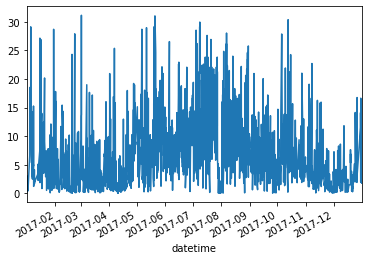

In [10]:
gs_obs.plot()

In [11]:
print('lai_max is {}'.format(lai_max))

lai_max is 5.0


# Splitting the data to test and train

In [12]:
df_forcing_train, df_forcing_test, gs_train, gs_test = train_test_split(df_forcing, gs_obs, test_size=0.6, random_state=42)

In [13]:
kd=df_forcing_train.kdown
ta=df_forcing_train.Tair
rh=df_forcing_train.RH
pa=df_forcing_train.pres
smd=df_forcing_train.xsmd
lai=df_forcing_train.lai

# Optimization

## More info in [here](https://platypus.readthedocs.io/en/latest/getting-started.html#)

In [14]:
def fun_to_opts(G):
    [g1,g2, g3, g4, g5, g6]=[G[0],G[1],G[2],G[3],G[4],G[5]]
    gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_z=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)
    gs_obs=gs_train
    o1=abs(1-np.std(gs_model)/np.std(gs_obs)) # normilized std difference
    o2=np.mean(abs(gs_model-gs_obs))/(np.mean(gs_obs))
    return [o1,o2],[gs_model.min()]

In [15]:
problem = Problem(6,2,1)
problem.types[0] = Real(.09, .5)
problem.types[1] = Real(100, 500)
problem.types[2] = Real(0, 1)
problem.types[3] = Real(0.4, 1)
problem.types[4] = Real(25, 55)
problem.types[5] = Real(0.02, 0.03)

problem.constraints[0] = ">=0"

problem.function = fun_to_opts
random.seed(12345)
algorithm=CMAES(problem, epsilons=[0.005])
algorithm.run(3000)


In [16]:
print( " Obj1\t Obj2")

for solution in algorithm.result[:10]:
    print ("%0.3f\t%0.3f" % tuple(solution.objectives))

 Obj1	 Obj2
0.073	0.555
0.112	0.545
0.161	0.534
0.056	0.560
0.003	0.579
0.092	0.550
0.199	0.530
0.133	0.540
0.026	0.570
0.014	0.575


## It shows how two objective changes

Text(0, 0.5, 'objective 2')

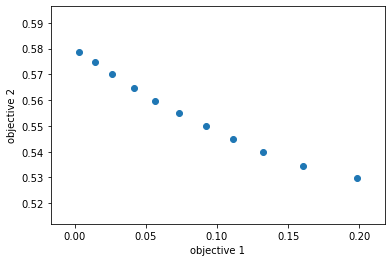

In [17]:
f, ax = plt.subplots(1, 1)
plt.scatter([s.objectives[0] for s in algorithm.result],
           [s.objectives[1] for s in algorithm.result])
plt.xlabel('objective 1')
plt.ylabel('objective 2')

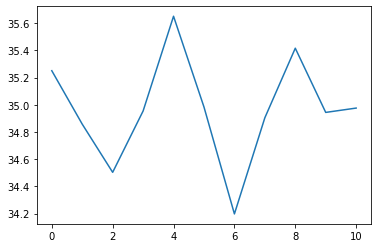

In [18]:
all_G={
      'g2':[],
      'g3':[],
      'g4':[],
      'g5':[],
      'g6':[]
      }
for s in algorithm.result:
        all_G['g2'].append(s.variables[0])
        all_G['g3'].append(s.variables[1])
        all_G['g4'].append(s.variables[2])
        all_G['g5'].append(s.variables[3])
        all_G['g6'].append(s.variables[4])
plt.plot(all_G['g6'])

In [19]:
all_std=[s.objectives[0] for s in algorithm.result]
all_MAE=[s.objectives[1] for s in algorithm.result]
all_std=np.array(all_std)
all_MAE=np.array(all_MAE)

## Choosing between : the median of two objectives, where obj1 is max or where obj2 is max

In [20]:
method='median' # 'obj1' or 'obj2' or 'median'
colors= ['b','g','r','y']

if method == 'median':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.median(all_std))].min())[0][0]
elif method == 'obj1':
    idx_med=np.where(all_MAE==all_MAE[(all_std>=np.min(all_std))].max())[0][0]
elif method == 'obj2':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.max(all_std))].min())[0][0]
print(all_std[idx_med])
print(all_MAE[idx_med])


0.07329333444496555
0.5549996145597563


In [21]:
[g1,g2,g3,g4,g5,g6] = algorithm.result[idx_med].variables

In [22]:
with open('outputs/g1-g6/'+name+'-g1-g6.pkl','wb') as f:
    pickle.dump([g1,g2,g3,g4,g5,g6], f)

In [23]:
with open('outputs/g1-g6/'+name+'-g1-g6.pkl','rb') as f:
    [g1,g2,g3,g4,g5,g6]=pickle.load(f)

In [24]:
pd.DataFrame([np.round([g1,g2,g3,g4,g5,g6],3)],columns=['g1','g2','g3','g4','g5','g6'],index=[name])

,g1,g2,g3,g4,g5,g6
US-MMS,0.431,104.34,0.634,0.683,35.25,0.03


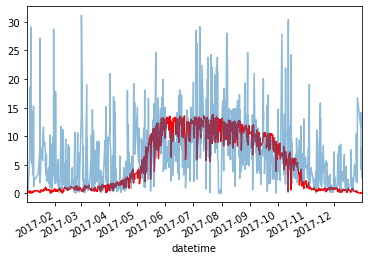

In [25]:
gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_max=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)

gs_model.plot(color='r')
gs_train.plot(alpha=0.5)

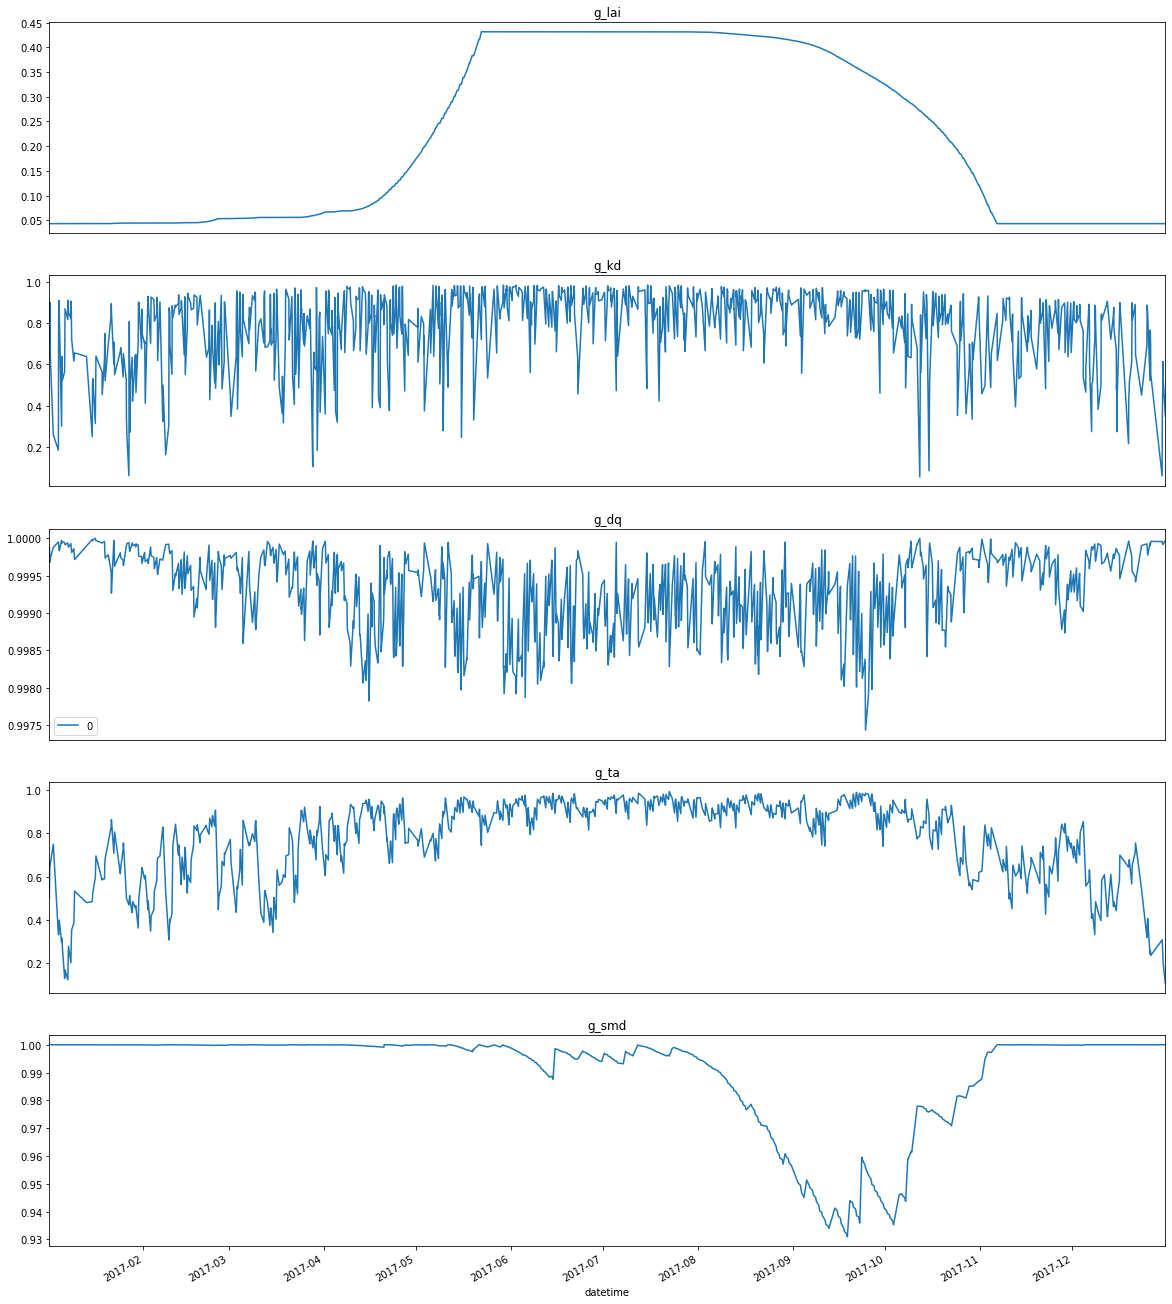

In [26]:
g_dq=pd.DataFrame(g_dq,index=g_lai.index)
fig,axs=plt.subplots(5,1,figsize=(20,25))
a={'0':g_lai,'1':g_kd,'2':g_dq,'3':g_ta,'4':g_smd}
b={'0':'g_lai','1':'g_kd','2':'g_dq','3':'g_ta','4':'g_smd'}
for i in range(0,5):
    ax=axs[i]
    a[str(i)].plot(ax=ax)
    ax.set_title(b[str(i)])
    if i!=4:
        ax.set_xticks([''])
        ax.set_xlabel('')
    
    

## Running Supy with new g1-g6

2020-02-06 14:16:27,395 — SuPy — INFO — All cache cleared.
2020-02-06 14:16:28,323 — SuPy — INFO — All cache cleared.
2020-02-06 14:16:31,028 — SuPy — INFO — ====================
2020-02-06 14:16:31,028 — SuPy — INFO — Simulation period:
2020-02-06 14:16:31,029 — SuPy — INFO —   Start: 2016-12-31 23:05:00
2020-02-06 14:16:31,030 — SuPy — INFO —   End: 2017-12-31 23:00:00
2020-02-06 14:16:31,032 — SuPy — INFO — 
2020-02-06 14:16:31,033 — SuPy — INFO — No. of grids: 1
2020-02-06 14:16:31,034 — SuPy — INFO — SuPy is running in serial mode
2020-02-06 14:16:56,247 — SuPy — INFO — Execution time: 25.2 s
2020-02-06 14:16:56,248 — SuPy — INFO — ====================



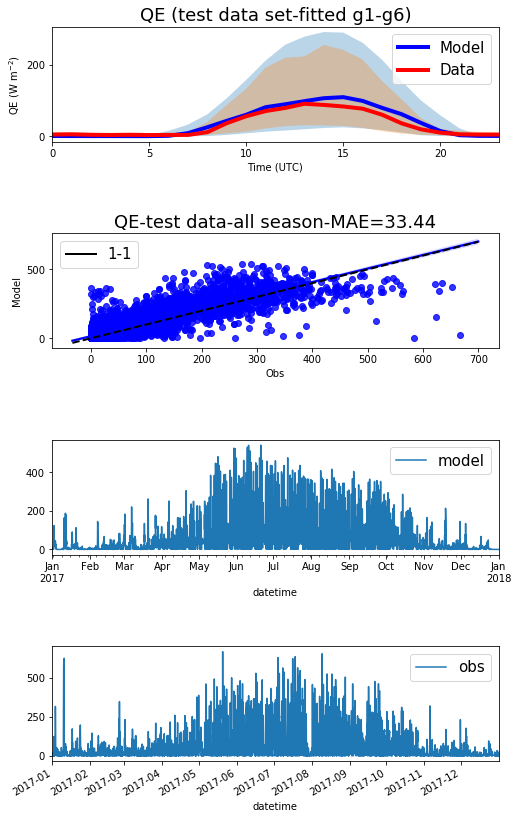

In [27]:
alpha=2.6 # need to be tuned iteratively
name='US-MMS'
year=year
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha)

In [28]:
g1=g1*alpha
g_max=g1*g_max
g1=1

In [29]:
g_max

37.03471400427182

# Creating the table for all sites here

In [30]:
sites=['US-MMS']
g1_g6_all=pd.DataFrame(columns=['g1','g2','g3','g4','g5','g6'])

for s in sites:
    with open('outputs/g1-g6/'+s+'-g1-g6.pkl','rb') as f:
        g1_g6_all.loc[s,:]=pickle.load(f)
g1_g6_all  

,g1,g2,g3,g4,g5,g6
US-MMS,0.431336,104.34,0.633861,0.682953,35.25,0.0298504


# To test

## US-MMS-2016

In [31]:
g_max=37.93609433834938

2020-02-06 14:17:01,546 — SuPy — INFO — All cache cleared.
2020-02-06 14:17:02,550 — SuPy — INFO — All cache cleared.
2020-02-06 14:17:05,248 — SuPy — INFO — ====================
2020-02-06 14:17:05,250 — SuPy — INFO — Simulation period:
2020-02-06 14:17:05,254 — SuPy — INFO —   Start: 2015-12-31 23:05:00
2020-02-06 14:17:05,256 — SuPy — INFO —   End: 2016-12-31 23:00:00
2020-02-06 14:17:05,258 — SuPy — INFO — 
2020-02-06 14:17:05,260 — SuPy — INFO — No. of grids: 1
2020-02-06 14:17:05,262 — SuPy — INFO — SuPy is running in serial mode
2020-02-06 14:17:28,320 — SuPy — INFO — Execution time: 23.1 s
2020-02-06 14:17:28,321 — SuPy — INFO — ====================



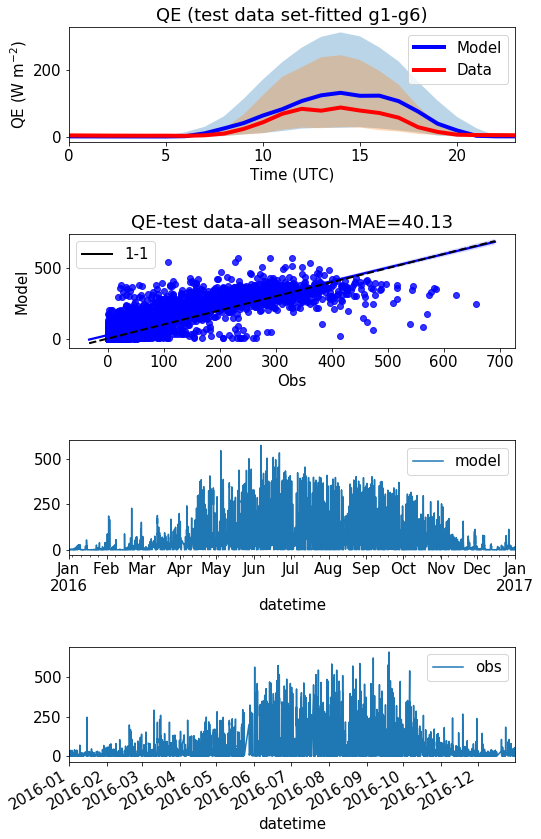

In [32]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['US-MMS',:].values
g_max=g_max
g1=1
s1=5.56


name='US-MMS'
year=2016
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year)

## UMB-2014

2020-02-06 14:17:32,510 — SuPy — INFO — All cache cleared.
2020-02-06 14:17:33,355 — SuPy — INFO — All cache cleared.
2020-02-06 14:17:36,046 — SuPy — INFO — ====================
2020-02-06 14:17:36,047 — SuPy — INFO — Simulation period:
2020-02-06 14:17:36,048 — SuPy — INFO —   Start: 2013-12-31 23:05:00
2020-02-06 14:17:36,049 — SuPy — INFO —   End: 2014-12-31 23:00:00
2020-02-06 14:17:36,050 — SuPy — INFO — 
2020-02-06 14:17:36,052 — SuPy — INFO — No. of grids: 1
2020-02-06 14:17:36,053 — SuPy — INFO — SuPy is running in serial mode
2020-02-06 14:17:49,916 — SuPy — INFO — Execution time: 13.9 s
2020-02-06 14:17:49,917 — SuPy — INFO — ====================



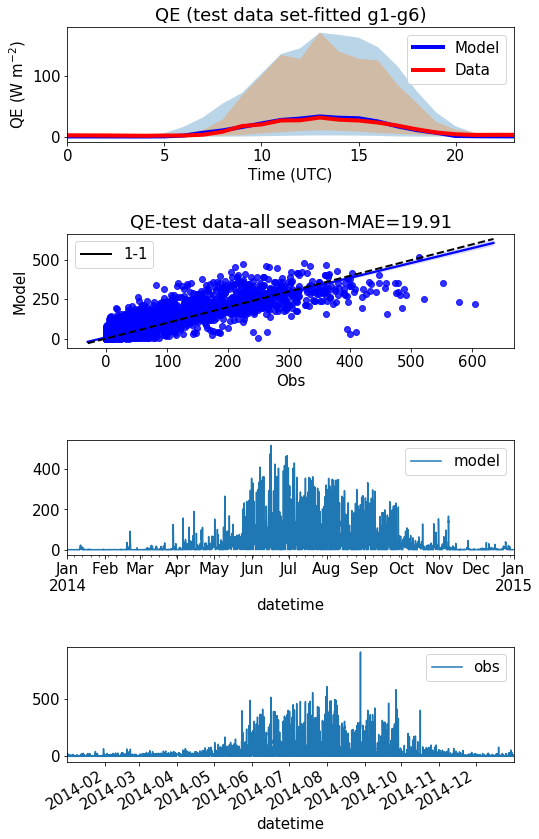

In [33]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['US-MMS',:].values
g_max=g_max
g1=1
s1=5.56

name='US-UMB'
year=2014
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year)

## US-Oho 2011

2020-02-06 14:17:54,541 — SuPy — INFO — All cache cleared.
2020-02-06 14:17:55,446 — SuPy — INFO — All cache cleared.
2020-02-06 14:17:58,077 — SuPy — INFO — ====================
2020-02-06 14:17:58,080 — SuPy — INFO — Simulation period:
2020-02-06 14:17:58,081 — SuPy — INFO —   Start: 2010-12-31 23:05:00
2020-02-06 14:17:58,083 — SuPy — INFO —   End: 2011-12-31 23:00:00
2020-02-06 14:17:58,085 — SuPy — INFO — 
2020-02-06 14:17:58,088 — SuPy — INFO — No. of grids: 1
2020-02-06 14:17:58,090 — SuPy — INFO — SuPy is running in serial mode
2020-02-06 14:18:14,025 — SuPy — INFO — Execution time: 15.9 s
2020-02-06 14:18:14,026 — SuPy — INFO — ====================



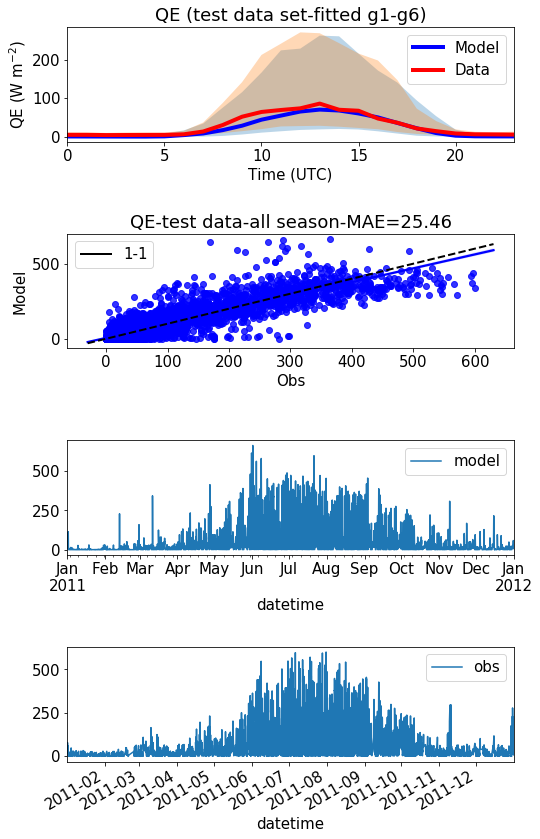

In [34]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['US-MMS',:].values
g_max=g_max
g1=1
s1=5.56

name='US-Oho'
year=2011
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year)